Upload data to colab

In [4]:
!unzip "/content/DATA.zip" -d "/content"

Archive:  /content/DATA.zip
   creating: /content/DATA/
   creating: /content/DATA/TEST/
   creating: /content/DATA/TEST/ANNOTATION/
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0001.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0002.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0003.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0004.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0005.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0006.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0007.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0008.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0009.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0010.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0011.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0012.txt  
  inflating: /content/DATA/TEST/ANNOTATION/test-annot-0013.txt  
  inflating: /content/

In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, hd_dir, lr_size, hr_size, hd_size, transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.hd_dir = hd_dir
        self.lr_size = lr_size
        self.hr_size = hr_size
        self.hd_size = hd_size
        self.transform = transform

        self.lr_images = sorted([os.path.join(self.lr_dir, img) for img in os.listdir(self.lr_dir) if img.endswith('.pgm')])
        self.hr_images = sorted([os.path.join(self.hr_dir, img) for img in os.listdir(self.hr_dir) if img.endswith('.pgm')])
        self.hd_images = sorted([os.path.join(self.hd_dir, img) for img in os.listdir(self.hd_dir) if img.endswith('.pgm')])

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image_path = self.lr_images[idx]
        hr_image_path = self.hr_images[idx]
        hd_image_path = self.hd_images[idx]

        # Debugging: print the file paths being accessed
        '''print(f"Loading LR image from: {lr_image_path}")
        print(f"Loading HR image from: {hr_image_path}")
        print(f"Loading HD image from: {hd_image_path}")'''

        lr_image = Image.open(lr_image_path)
        hr_image = Image.open(hr_image_path)
        hd_image = Image.open(hd_image_path)

        # Apply resizing transforms
        lr_image = transforms.Resize(self.lr_size)(lr_image)
        hr_image = transforms.Resize(self.hr_size)(hr_image)
        hd_image = transforms.Resize(self.hd_size)(hd_image)

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)
            hd_image = self.transform(hd_image)

        return {'lr': lr_image, 'hr': hr_image, 'hd': hd_image}

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Paths to the data directories/content/DATA/TRAIN/HD
'''
train_lr_dir = '/content/DATA/TRAIN/LR'
train_hr_dir = '/content/DATA/TRAIN/HR'
train_hd_dir = '/content/DATA/TRAIN/HD'

test_lr_dir = '/content/DATA/TEST/LR'
test_hr_dir = '/content/DATA/TEST/HR'
test_hd_dir = '/content/DATA/TEST/HD'
'''

train_lr_dir = './DATA/TRAIN/LR'
train_hr_dir = './DATA/TRAIN/HR'
train_hd_dir = './DATA/TRAIN/HD'

test_lr_dir = './DATA/TEST/LR'
test_hr_dir = './DATA/TEST/HR'
test_hd_dir = './DATA/TEST/HD'

# Create the training and test datasets with specified sizes
train_dataset = SuperResolutionDataset(
    lr_dir=train_lr_dir,
    hr_dir=train_hr_dir,
    hd_dir=train_hd_dir,
    lr_size=(13, 137),
    hr_size=(26, 274),
    hd_size=(52, 548),
    transform=transform
)
test_dataset = SuperResolutionDataset(
    lr_dir=test_lr_dir,
    hr_dir=test_hr_dir,
    hd_dir=test_hd_dir,
    lr_size=(13, 137),
    hr_size=(26, 274),
    hd_size=(52, 548),
    transform=transform
)



# Create the dataloaders with reduced num_workers
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, drop_last=True)

# Example of iterating through the dataloader
for batch in train_loader:
    lr_images = batch['lr']
    hr_images = batch['hr']
    hd_images = batch['hd']
    print(f"LR batch shape: {lr_images.size()}")
    print(f"HR batch shape: {hr_images.size()}")
    print(f"HD batch shape: {hd_images.size()}")
    break


LR batch shape: torch.Size([8, 1, 13, 137])
HR batch shape: torch.Size([8, 1, 26, 274])
HD batch shape: torch.Size([8, 1, 52, 548])


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Updated SRCNN Model Definition
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=1)
        self.conv3 = nn.Conv2d(32, 1, kernel_size=5, padding=2)
        self.upscale = nn.ConvTranspose2d(1, 1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)
        x = self.upscale(x)
        return x

# Updated Training and Validation Function for SRCNN
def train_srcnn(train_loader, test_loader, model, criterion, optimizer, num_epochs=75):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in train_loader:
            lr = batch['lr'].to(device)
            hr = batch['hr'].to(device)
            
            optimizer.zero_grad()
            output = model(lr)
            loss = criterion(output, hr)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Training Loss: {train_loss/len(train_loader)}')
        
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for batch in test_loader:
                lr = batch['lr'].to(device)
                hr = batch['hr'].to(device)
                
                output = model(lr)
                loss = criterion(output, hr)
                
                val_loss += loss.item()
            
            print(f'Epoch {epoch+1}, Validation Loss: {val_loss/len(test_loader)}')

# Initialize and Train SRCNN
srcnn_model = SRCNN().to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(srcnn_model.parameters(), lr=1e-4)

In [6]:
import os

def save_model(model, path):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"Model loaded from {path}")


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training function for SRCNN, SIREN, and NeRV remains the same
# SRCNN Training
#srcnn_model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(srcnn_model.parameters(), lr=1e-4)
train_srcnn(train_loader, test_loader, srcnn_model, criterion, optimizer,num_epochs=200)
save_model(srcnn_model, "srcnn_model.pth")
load_model(srcnn_model, "srcnn_model.pth")



Epoch 1, Training Loss: 0.23662820564849035
Epoch 1, Validation Loss: 0.21433342379682205
Epoch 2, Training Loss: 0.1978856598692281
Epoch 2, Validation Loss: 0.18875683405820062
Epoch 3, Training Loss: 0.17188782042690687
Epoch 3, Validation Loss: 0.1611875107183176
Epoch 4, Training Loss: 0.1445774918156011
Epoch 4, Validation Loss: 0.1330063084469122
Epoch 5, Training Loss: 0.1185025090617793
Epoch 5, Validation Loss: 0.10703184762421776
Epoch 6, Training Loss: 0.09466569434319223
Epoch 6, Validation Loss: 0.08494531582383548
Epoch 7, Training Loss: 0.0754605732858181
Epoch 7, Validation Loss: 0.06746857306536506
Epoch 8, Training Loss: 0.060556469591600555
Epoch 8, Validation Loss: 0.05420862817588974
Epoch 9, Training Loss: 0.04873860872217587
Epoch 9, Validation Loss: 0.044191709555247254
Epoch 10, Training Loss: 0.040493474767676424
Epoch 10, Validation Loss: 0.03697086388573927
Epoch 11, Training Loss: 0.03427257194582905
Epoch 11, Validation Loss: 0.031631224843509054
Epoch 12

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

# Define the PSNR function
def psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:  # MSE is zero means no noise is present in the signal.
                 # Therefore PSNR is infinite
        return 100
    PIXEL_MAX = 1.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))

# Define the SSIM function
def ssim(img1, img2):
    return compare_ssim(img1, img2, data_range=img2.max() - img2.min())

# Evaluate model function
def evaluate_model1(model, test_loader):
    psnr_values = []
    ssim_values = []
    # ms_ssim_values = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            lr = batch['lr'].to(device)
            hr = batch['hr'].to(device)
            output = model(lr)

            # Assuming output and hr are normalized to [0, 1]
            output_np = output.squeeze().cpu().numpy()
            hr_np = hr.squeeze().cpu().numpy()

            # Normalize the images between 0 and 1
            output_np = (output_np - output_np.min()) / (output_np.max() - output_np.min())
            hr_np = (hr_np - hr_np.min()) / (hr_np.max() - hr_np.min())

            for i in range(output_np.shape[0]):
                psnr_values.append(psnr(hr_np[i], output_np[i]))
                ssim_values.append(ssim(hr_np[i], output_np[i]))

    print(f'Average PSNR: {np.mean(psnr_values)}, Average SSIM: {np.mean(ssim_values)}')
    return psnr_values, ssim_values




In [17]:
evaluate_model1(srcnn_model, test_loader)


Average PSNR: 20.43460842876475, Average SSIM: 0.8107648797271774


([19.05712453741608,
  19.0079525838028,
  20.456157970438866,
  22.093026632358125,
  21.318868761483962,
  19.096650683427132,
  18.882518680762406,
  17.79869338767247,
  18.012572886660426,
  19.97739203924263,
  24.895976869263052,
  24.933400704128566,
  19.553468758882712,
  24.09006839041062,
  25.12462512119535,
  14.36282336502579,
  27.733203514872642,
  20.991118076643417,
  25.621176216518666,
  27.10107611152569,
  17.650076017543547,
  21.51946748138642,
  20.435177741357894,
  23.85139348846044,
  24.79180102997102,
  21.964164829580298,
  20.95899355954439,
  19.405521699535797,
  21.800334008911435,
  18.928439434417857,
  18.08372173263654,
  20.60676928675301,
  17.56682100866644,
  20.657812909980464,
  17.60133952812891,
  18.78924673326579,
  22.545177914957527,
  25.641784638847117,
  17.483040850266775,
  17.695220284783545,
  14.498843688324072,
  18.482945805458225,
  14.015146867370923,
  17.71648997353152,
  25.314051508223105,
  17.362541041196472,
  17.50

In [18]:
import matplotlib.pyplot as plt

def visualize_output1(model, test_loader):
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            lr = batch['lr'].to(device)
            hr = batch['hr'].to(device)
            output = model(lr)

            lr_np = lr.squeeze().cpu().numpy()[0]  # Display only the first image in the batch
            hr_np = hr.squeeze().cpu().numpy()[0]  # Display only the first image in the batch
            output_np = output.squeeze().cpu().numpy()[0]  # Display only the first image in the batch



            fig, axes = plt.subplots(8, 3, figsize=(15, 5))
            axes[0].imshow(lr_np, cmap='gray')
            axes[0].set_title('LR Image')
            axes[1].imshow(hr_np, cmap='gray')
            axes[1].set_title('HR Image')
            axes[2].imshow(output_np, cmap='gray')
            axes[2].set_title('Output Image')

            plt.show()
            return output  # Show only the first batch for visualization


In [19]:
def visualize_output(model, test_loader):
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            lr = batch['lr'].to(device)
            hr = batch['hr'].to(device)
            output = model(lr)

            # Ensure only the first 8 images are visualized
            fig, axes = plt.subplots(8, 3, figsize=(15, 40))
            fig.tight_layout(pad=3.0)

            for i in range(8):
                lr_np = lr[i].squeeze().cpu().numpy()  # Get the ith LR image
                hr_np = hr[i].squeeze().cpu().numpy()  # Get the ith HR image
                output_np = output[i].squeeze().cpu().numpy()  # Get the ith output image

                axes[i, 0].imshow(lr_np, cmap='gray')
                axes[i, 0].set_title(f'LR Image {i+1}')
                axes[i, 0].axis('off')

                axes[i, 1].imshow(hr_np, cmap='gray')
                axes[i, 1].set_title(f'HR Image {i+1}')
                axes[i, 1].axis('off')

                axes[i, 2].imshow(output_np, cmap='gray')
                axes[i, 2].set_title(f'Output Image {i+1}')
                axes[i, 2].axis('off')

            plt.show()
            return output  # Show only the first batch for visualization


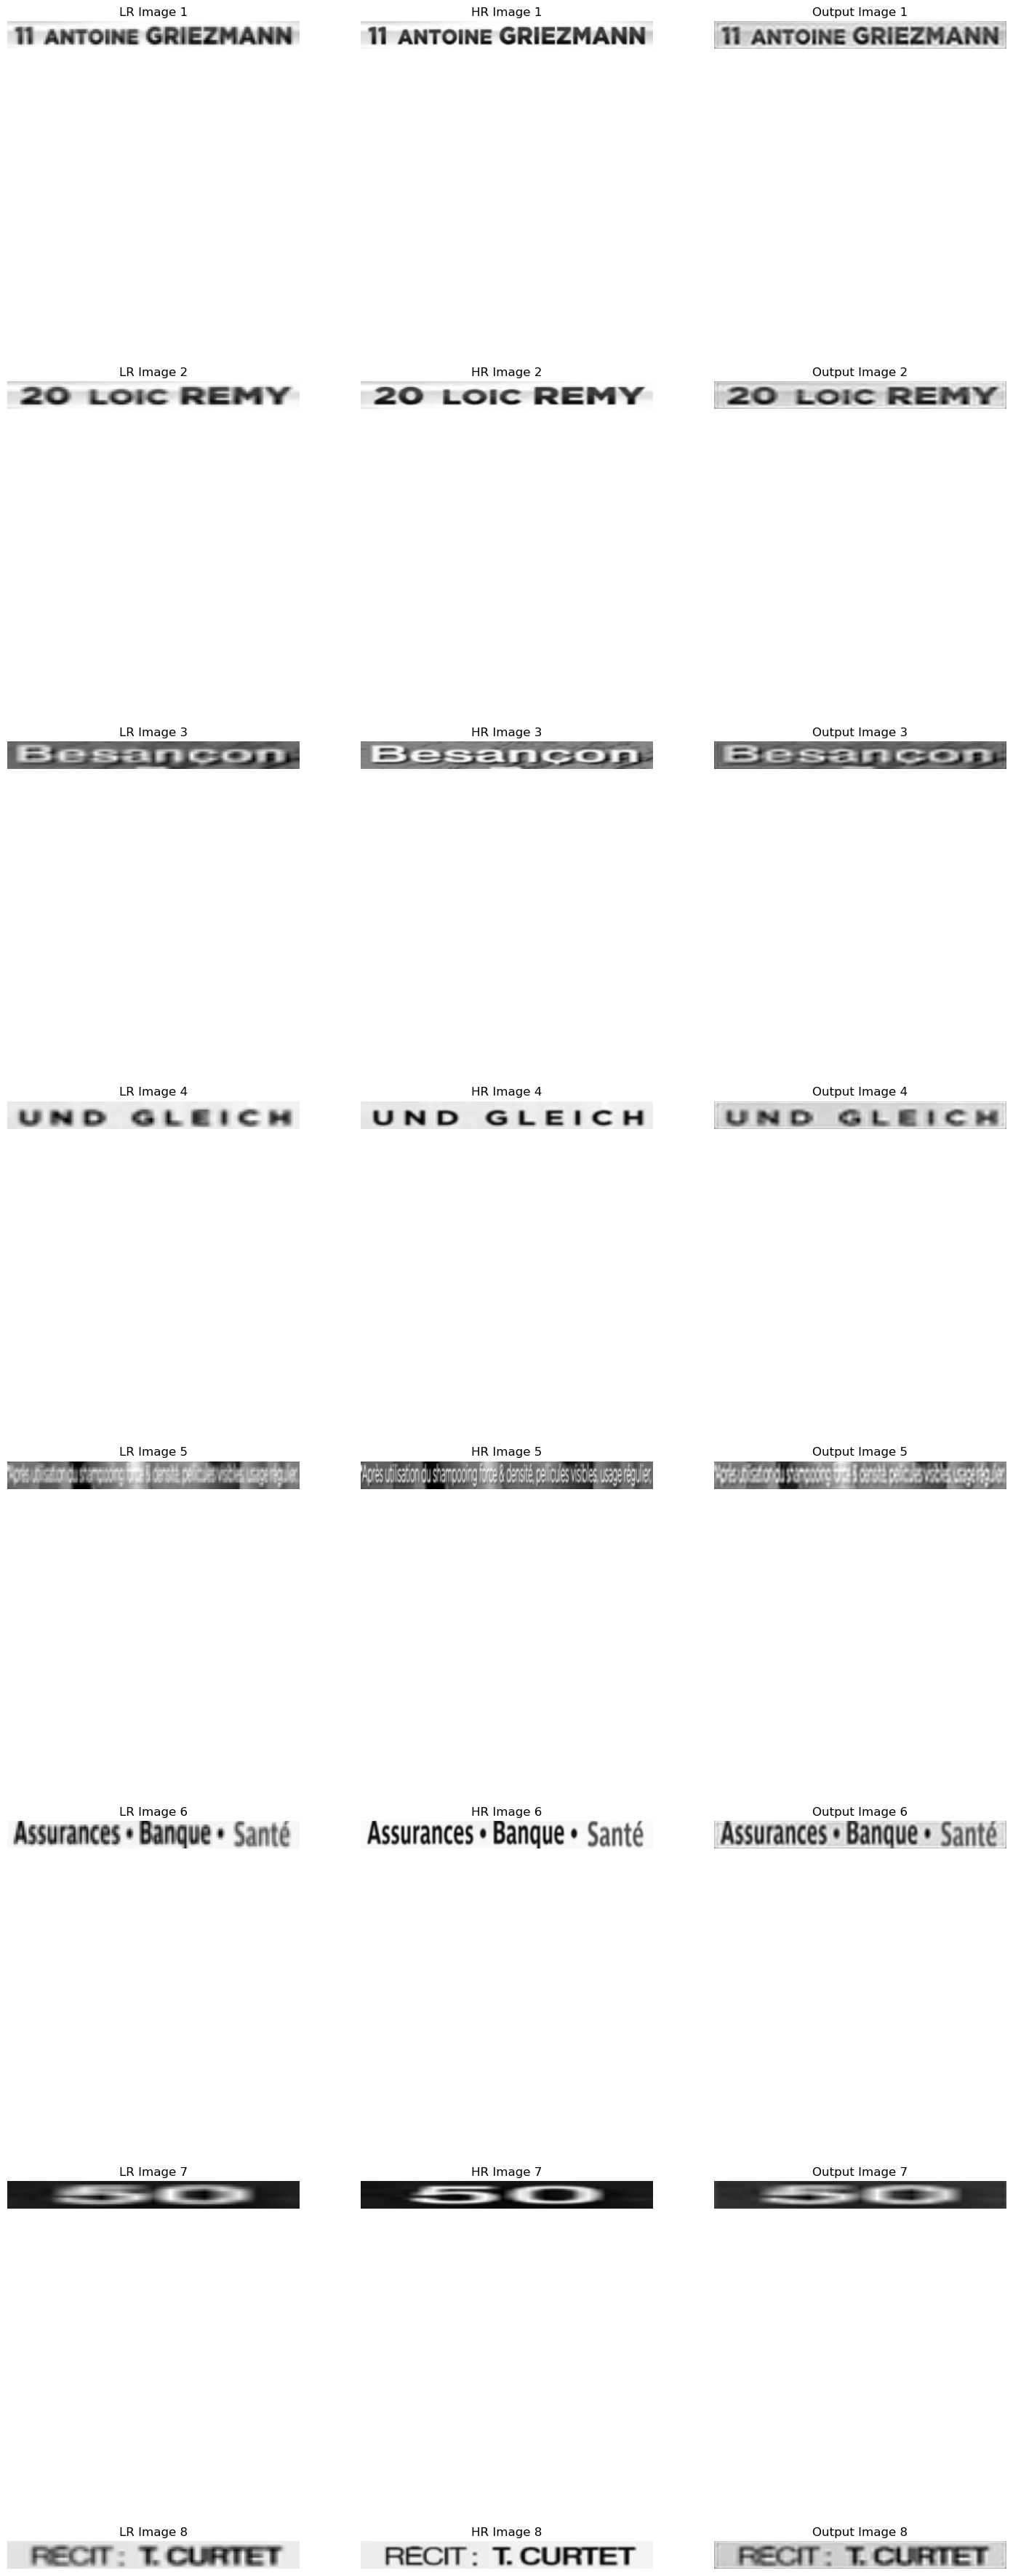

In [20]:
output1=visualize_output(srcnn_model, test_loader)


In [21]:
import matplotlib.pyplot as plt

def visualize_inputs(test_loader):
    with torch.no_grad():
        for batch in test_loader:
            lr=batch['lr']
            print(lr.size())
            lr = batch['lr'].cpu().numpy()  # Swap axes to (batch, height, width, channels)
            hr = batch['hr'].cpu().numpy()  # Swap axes to (batch, height, width, channels)




            fig, axes = plt.subplots(2, len(lr), figsize=(25, 4))
            for i in range(len(lr)):
                axes[0, i].imshow(lr[i].squeeze(), cmap='gray')
                axes[0, i].set_title(f'LR Image {i+1}')
                axes[1, i].imshow(hr[i].squeeze(), cmap='gray')
                axes[1, i].set_title(f'HR Image {i+1}')

            plt.show()
            break  # Show only the first batch for visualization


torch.Size([8, 1, 13, 137])


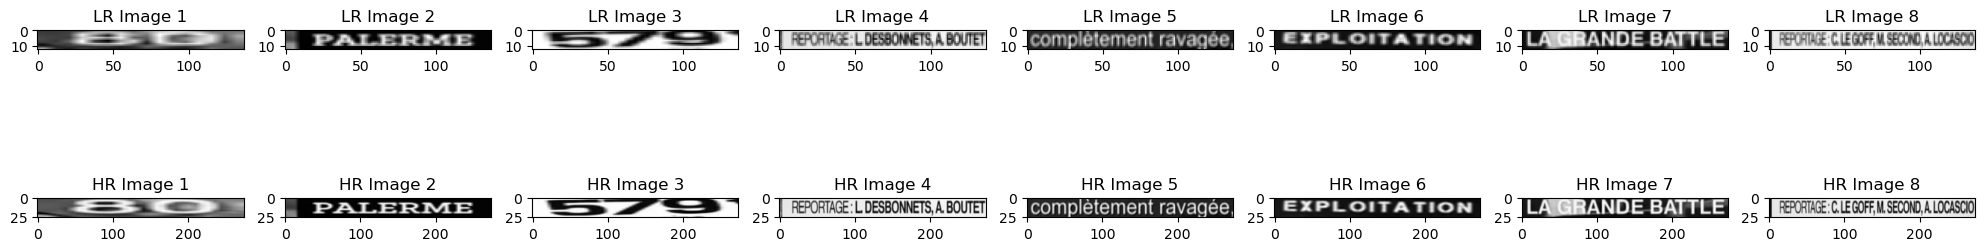

In [22]:
visualize_inputs(train_loader)

# OCR results

In [5]:
!pip install transformers
!pip install datasets
!pip install torch
!pip install torchvision


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 

In [79]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import numpy as np

# Load the pre-trained model and processor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

# Function to convert grayscale image tensor to RGB
def convert_grayscale_to_rgb(image_tensor):
    # Assuming image_tensor is in the format [batch_size, 1, height, width]
    return image_tensor.repeat(1, 3, 1, 1)  # Repeat the single channel to create 3 channels

# Function to perform OCR on a batch of image tensors
def ocr_from_tensors(image_tensors):
    # Ensure the model is in evaluation mode
    model.eval()

    # Convert grayscale images to RGB
    image_tensors_rgb = convert_grayscale_to_rgb(image_tensors)

    # Normalize the image tensors to the range [0, 1]
    image_tensors_rgb = torch.clamp(image_tensors_rgb, min=0, max=1)

    # Convert tensor to PIL images
    pil_images = [Image.fromarray((img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)) for img in image_tensors_rgb]

    # Create the pixel values for the processor
    pixel_values = processor(images=pil_images, return_tensors="pt").pixel_values

    # Generate text predictions using the model
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    # Decode the generated text
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_text

# Example usage
# Assuming you have a batch of image tensors in the format [batch_size, channels, height, width]
# Here we create a dummy tensor as an example

# Perform OCR on the image tensors
text_predictions = ocr_from_tensors(output1)
for i, text in enumerate(text_predictions):
    print(f"Image {i+1}: {text}")


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Image 1: " It announce GRIZZMAN
Image 2: 20 Rocky.
Image 3: the first appearance of the American American Revolution
Image 4: und which
Image 5: What links here has multiple issues Please help improve it by
Image 6: Assurances - Banque - Santel
Image 7: 1902 03
Image 8: " Freeciti, to clarifatize it.


In [93]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import numpy as np

# Load the pre-trained model and processor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

# Function to convert grayscale image tensor to RGB
def convert_grayscale_to_rgb(image_tensor):
    # Assuming image_tensor is in the format [batch_size, 1, height, width]
    return image_tensor.repeat(1, 3, 1, 1)  # Repeat the single channel to create 3 channels

# Function to perform OCR on a batch of image tensors
def ocr_from_tensors(image_tensors):
    # Ensure the model is in evaluation mode
    model.eval()

    # Convert grayscale images to RGB
    image_tensors_rgb = convert_grayscale_to_rgb(image_tensors)

    # Normalize the image tensors to the range [0, 1]
    image_tensors_rgb = torch.clamp(image_tensors_rgb, min=0, max=1)

    # Convert tensor to PIL images
    pil_images = [Image.fromarray((img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)) for img in image_tensors_rgb]

    # Create the pixel values for the processor
    pixel_values = processor(images=pil_images, return_tensors="pt").pixel_values

    # Generate text predictions using the model
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    # Decode the generated text
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_text

# Example usage
# Assuming you have a batch of image tensors in the format [batch_size, channels, height, width]
# Here we create a dummy tensor as an example

# Perform OCR on the image tensors
text_predictions = ocr_from_tensors(output1)
for i, text in enumerate(text_predictions):
    print(f"Image {i+1}: {text}")


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Image 1: 11 Antoine Griezmann
Image 2: 20tocremy.
Image 3: bibliography
Image 4: undalmich
Image 5: vteUnited States Senatorial Service
Image 6: Assurances - Banque - Sante
Image 7: 0 1
Image 8: precht.T.quartet.


In [98]:
import torch
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import numpy as np

# Load the pre-trained model and processor
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-base-handwritten')
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

# Function to convert grayscale image tensor to RGB
def convert_grayscale_to_rgb(image_tensor):
    # Assuming image_tensor is in the format [batch_size, 1, height, width]
    return image_tensor.repeat(1, 3, 1, 1)  # Repeat the single channel to create 3 channels

# Function to perform OCR on a batch of image tensors
def ocr_from_tensors(image_tensors):
    # Ensure the model is in evaluation mode
    model.eval()

    # Convert grayscale images to RGB
    image_tensors_rgb = convert_grayscale_to_rgb(image_tensors)

    # Normalize the image tensors to the range [0, 1]
    image_tensors_rgb = torch.clamp(image_tensors_rgb, min=0, max=1)

    # Convert tensor to PIL images
    pil_images = [Image.fromarray((img.permute(1, 2, 0).numpy() * 255).astype(np.uint8)) for img in image_tensors_rgb]

    # Create the pixel values for the processor
    pixel_values = processor(images=pil_images, return_tensors="pt").pixel_values

    # Generate text predictions using the model
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    # Decode the generated text
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)

    return generated_text

# Example usage
# Assuming you have a batch of image tensors in the format [batch_size, channels, height, width]
# Here we create a dummy tensor as an example

# Perform OCR on the image tensors
text_predictions = ocr_from_tensors(output1)
for i, text in enumerate(text_predictions):
    print(f"Image {i+1}: {text}")


Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Image 1: 11 Antoine Griezmann
Image 2: 20tocremy.
Image 3: bibliography
Image 4: undalmich
Image 5: vteUnited States Senatorial Service
Image 6: Assurances - Banque - Sante
Image 7: 0 1
Image 8: preciti to combat.
